# <span style="color:green"><center>Diplomado en Inteligencia Artificial y Aprendizaje Profundo</center></span>

# <span style="color:red"><center>Pronóstico de Series de Tiempo en Tensorflow</center></span>

## <span style="color:blue">Escritor</span>

1. Oleg Jarma, ojarmam@unal.edu.co 

##   <span style="color:blue">Profesores</span>

2. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
3. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
4. Campo Elías Pardo Turriago, cepardot@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

5. Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

6. Laura Lizarazo, ljlizarazore@unal.edu.co 
7. Julieth Lopez, julalopezcas@unal.edu.co

## <span style="color:blue">Contenido</span> 

* [Introducción](#Introducción)
* [Variables a utilizar](#Variables-a-utilizar)
  - [Base de Datos "Weather"](#Base-de-Datos-"Weather")
* [Modelo a un paso](#Modelo-a-un-paso)
  - [Modelo lineal](#Modelo-lineal)
  - [Denso Multi paso](#Denso-Multi-paso)
  - [Red Neuronal Convolucional](#Red-Neuronal-Convolucional)
  - [Red Recurrente](#Red-Recurrente)
  - [Modelos multivariados](#Modelos-multivariados)
* [Modelo multi paso](#Modelo-multi-paso)
  - [Modelos Single shot](#Modelos-Single-shot)
  - [Lineal](#Lineal)
  - [Densa](#Densa)
  - [CNN](#CNN)
  - [RNN](#RNN)
  - [Modelo Autorregresivo](#Modelo-Autorregresivo)






    


  


## <span style="color:blue">Introducción</span> 

Basado en este [tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model)

Observaremos cómo utilizar redes neuronales para hacer pronósticos de series de tiempo. Se utilizarán Redes Recurrentes y Redes Convolucionales.

En esta guía veremos:
- Pronóstico a un paso
    - Una característica
    - Varias características
- Pronóstico de muchos pasos
    - Todos los pronósticos a la vez
    - Modelo autorregresivo

## <span style="color:blue">Variables a utilizar</span> 

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### <span style="color:red">Base de Datos "Weather"</span>

Se utiliza la base de datos de clima del [Instituto Max Planck de Biogeoquímica](https://www.bgc-jena.mpg.de/wetter/). Esta cuenta con 14 variables como temperatura del aire y presión atmosférica. Se trabajará con datos entre 2009 y 2016 recolectados cada 10 minutos

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    # cache_dir='/media/storage', #dirección de extracción
    # cache_subdir='Datasets', #carpeta que se crea para la extracción
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
print(csv_path)

/home/thejarmanitor/.keras/datasets/jena_climate_2009_2016.csv


Aquí sólo se tratará con las observaciones por hora, así que se hará un sub muestreo en el que se recogerá cada sexto dato.

También se podría hacer una agregación de los datos con la función `df.resample('H', origin='start').agg('mean')` si se quiere resumir el comportamiento dentro de la hora

In [3]:
df = pd.read_csv(csv_path)

df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Hacemos la gráfica de algunas variables para ver su comportamiento

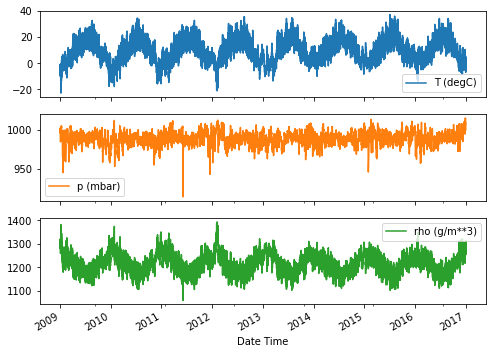

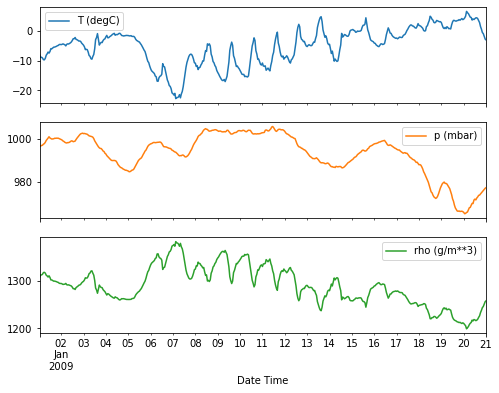

In [4]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### <span style="color:red">Inspección, limpieza e ingeniería de características</span>

Por supuesto, para poder generar un modelo correctamente, es necesario entender los datos

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


¿Qué llama la atención? el mínimo de las variables de velocidad de viento es -9999, un valor probablemente erroneo que puede causar problemas como sesgo.
Además, como se tiene una variable de la dirección del viento, la velocidad siempre debe ser mayor o igual a cero. Arreglemos esto

In [6]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# revisamos si los cambios se muestran en el dataframe
df['wv (m/s)'].min()

0.0

Ahora nos adentramos en cosas más específicas con algunas variables......

#### Viento

La columna de dirección del viento está en ángulos, lo cual no es buena variable de entrada para un modelo.

Veamos cómo se ven los datos de viento

Text(0, 0.5, 'Wind Velocity [m/s]')

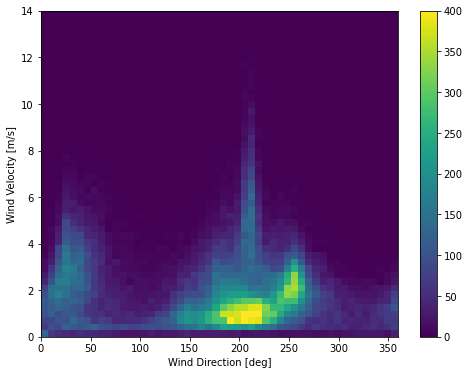

In [7]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Las variables de dirección y velocidad del viento serán más sencillas de interpretar para el modelo si las convertimos en vectores

In [8]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convertir a radianes.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calcular los componentes bidimensionales del viento.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Se repite el proceso con el viento máximo.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

La distribución del viento ahora será más fácil de entender

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

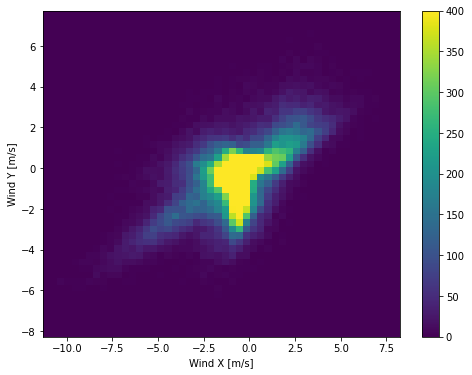

In [9]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Tiempo

Además, la columna de tiempo nos brindará información importante, pero hay que convertirla a algo verdaderamente utilizable

In [10]:
print(date_time)

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]


Como estos son datos climáticos, se puede suponer que se tiene tanto periodicidad en el día como en el año. Este pero los datos en este formato no lo repesentan correctamente. Para aprovechar esta información, usaremos transformaciones de seno y coseno.

In [11]:
#Convertimos los datos a segundos ##PELIGRO, NO USAR ASÍ

timestamp_s = date_time.map(pd.Timestamp.timestamp)

#obtenemos el seno y coseno para obtener señales más claras

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

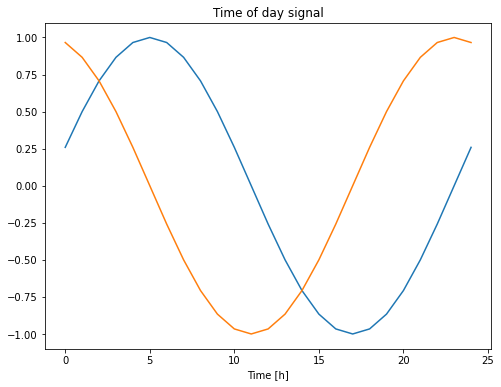

In [12]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

#### Separación de los datos

Haremos un clásico corte de los datos (70%, 20%, 10%) para entrenamiento, Validación y test. Que se note que no se está haciendo shuffle en este caso

In [13]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

#### Normalización de los datos

Práctica común para evitar sesgo en los datos. Aquí se hace manualmente

In [14]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Observemos las distribuciones de los datos

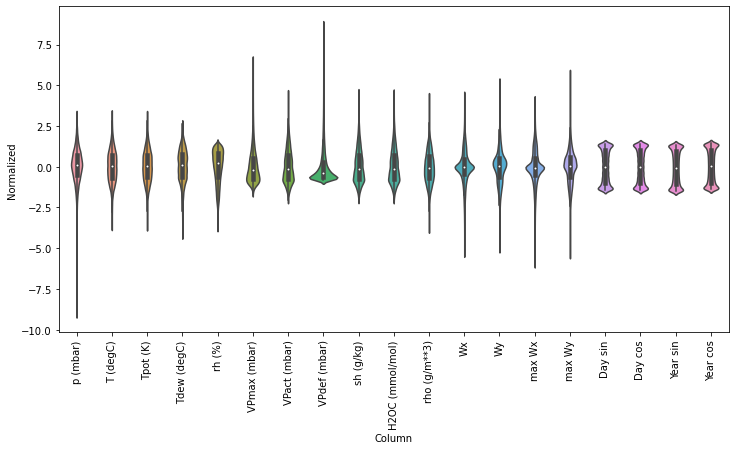

In [15]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

### <span style="color:red">Ventaneo de Datos</span>

Los modelos que usaremos tendrán como datos de entrada "ventanas" de datos consecutivos. Estas tienen las siguientes características:

- el numero de "pasos" de las ventanas de entrada y labels
- el "offset" entre los anteriores
- las variables que son usadas como entrada, labels o ambos.

Se van a construir distintas ventanas para modelos de salida univariada, salida multivariada, a un paso o multi paso.

Por ejemplo, definimos un modelo con ventanas de 24 horas en el pasado para predecir un paso a 24 en el futuro
<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/raw_window_24h.png" 
     alt="ventaneo_24-24" width="500">
<center>

O un modelo que predice una hora en el futuro, dadas 6 horas de historia
<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/raw_window_1h.png" 
     alt="ventaneo_6-1" width="500">
<center>

A continuación definiremos una clase llamada `windowGenerator` que sea capaz de:
- Manejar indices y offsets
- Hacer un ventaneo de pares `(variables, labels)`
- hacer gráficos de las ventanas
- Generar lotes de dichas ventanas para entrenamiento, validación y prueba

#### Índices y offsets

Comenzamos a generar la clase `WindowGenerator`. el método `__init__` define los indices de los datos de entrada y los labels

Luego toma los datos de entrenamiento, validación y prueba y los convierte en `tf.Data.Dataset`

In [16]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Guarda los datos en crudo
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Se trabajan las columnas de labels
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Definimos los parámetros de las ventanas
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    #Método para representar los objetos en forma de string

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Creamos las ventanas de los ejemplos

In [17]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [18]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

#### Corte

Dada una lista de entradas consecutivas, el método `split_window` hará la conversión a ventanas de entradas y labels

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/split_window.png" 
     alt="ventaneo_6-1" width="500">
<center>

In [19]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # El corte no conserva la información sobre la forma, 
    # Por eso es mejor definir las formas para llenar correctamente los datasets
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

#Definimos la función recién hecha como método de WindowGenerator
WindowGenerator.split_window = split_window

In [20]:
# Apilamos tres cortes, la longitud total de la ventana
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


2021-11-12 17:12:03.517136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 17:12:03.521967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 17:12:03.523533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 17:12:03.524807: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

#### Gráficas

Agregamos un método para visualizar los cortes de las ventanas

In [21]:
w2.example = example_inputs, example_labels

In [22]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

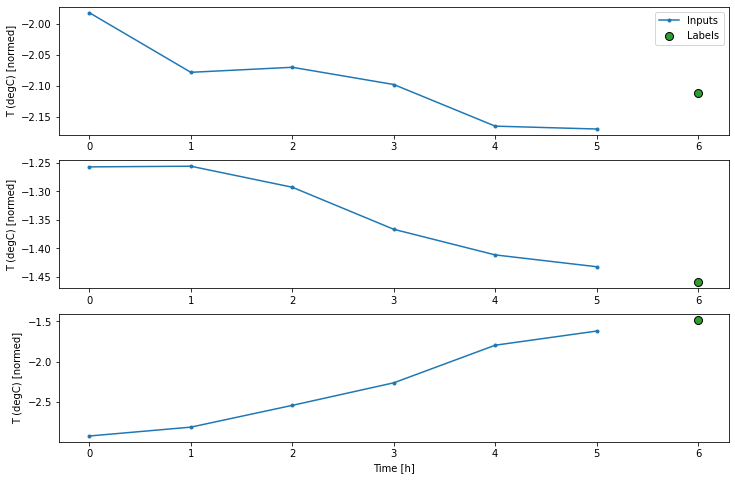

In [23]:
w2.plot()

#### Creación de Datasets

Finalmente, creamos un método que toma el Dataframe de series de tiempo y lo convierte en `tf.data.Dataset` como pares de forma `(input_window, label_window)`. esto se logra usando la función `preprocessing.timeseries_dataset_from_array`

In [24]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

Podemos agregar propiedades para poder acceder a los datos de entrenamiento, validación y prueba como Datasets de tensorflow, utilizando la función que acabamos de crear. Además agregamos un lote de ejemplo para gráficos rápidos

In [25]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Se toma y se guarda en el caché un lote de ejemplo de 'Entradas y labels' para gráficar"""
    result = getattr(self, '_example', None)
    if result is None:
        # No se encontró un lote, así que creamos uno del dataset '.train'
        result = next(iter(self.train))
        # se guarda en el caché para futuros usos
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Ahora tenemos acceso a los datasets como objetos de tensorflow!

E iterar sobre esos, genera lotes concretos

In [26]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [27]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


2021-11-12 17:12:04.522732: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### <span style="color:red">Modelo a un paso</span>

Este es el modelo más sencillo de construir.Predecimos una única variable con una historia de un paso a un paso en el futuro.

Comenzaremos prediciendo la variable `T (degC)`

Configuramos `WindowGenerator` para que produzca pares a un paso con la varible a predecir

In [28]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

Generamos los tres datasets e iteramos sobre ellos

In [29]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


#### Base de referencia

Antes de armar el modelo, es buena idea tener una base de referencia para el rendimiendo con respecto a los modelos más complejos

Aquí haremos un modelo que hace una predicción en el futuro dado los datos actuales. El modelo retorna la temperatura actual y predice si hubo cambios o no.

In [30]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instanciamos y evaluamos el modelo.

In [31]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 874us/step - loss: 0.0128 - mean_absolute_error: 0.0785


Lastimosamente estas métricas no nos dicen mucho de cómo trabaja el modelo

Podemos graficar las métricas de este modelo, pero la verdad no hay mucho que observar con una sola muestra.

Razón por la cual creamos una ventana de 24 horas de entradas consecutivas y labels de una vez. Esto no cambia lo que hace el modelo. Estamos haciendo una predicción cada hora durante 24 horas

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/last_window.png" 
     alt="ventaneo_6-1" width="500">
<center>

In [32]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [33]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Ahora si obtendremos gráficos más interesantes

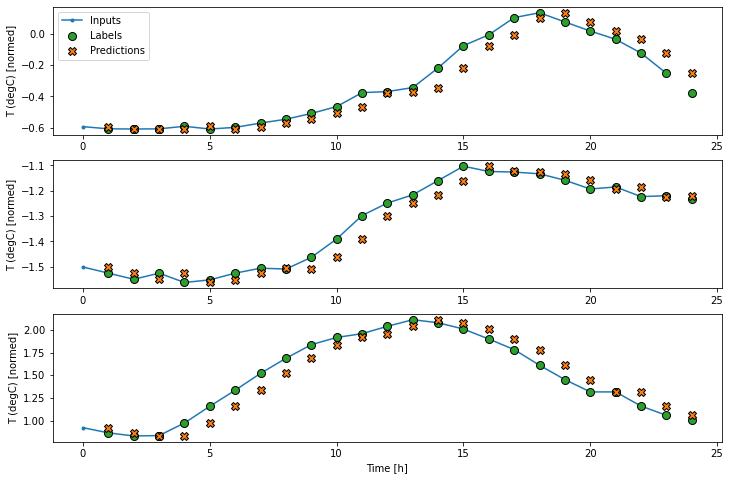

In [34]:
wide_window.plot(baseline)

#### Modelo Lineal

Aplicamos una transformación lineal entre la entrada y la salida.

Esto lo logramos con una capa densa sin función de activación

In [35]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [36]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [37]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [38]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0717 - mean_absolute_error: 0.1660 - val_loss: 0.0112 - val_mean_absolute_error: 0.0775
Epoch 2/20
1534/1534 [==============================] - 2s 2ms/step - loss: 0.0107 - mean_absolute_error: 0.0763 - val_loss: 0.0100 - val_mean_absolute_error: 0.0740
Epoch 3/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0100 - mean_absolute_error: 0.0739 - val_loss: 0.0095 - val_mean_absolute_error: 0.0721
Epoch 4/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0096 - mean_absolute_error: 0.0720 - val_loss: 0.0092 - val_mean_absolute_error: 0.0709
Epoch 5/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0093 - mean_absolute_error: 0.0711 - val_loss: 0.0091 - val_mean_absolute_error: 0.0707
Epoch 6/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0706 - val_loss: 0.0092 - val_mean_absolute_error: 0.0708
Epoc


Igual que el modelo anterior, este se puede aplicar en lotes de ventanas amplias, haciendo predicciones independientes de manera consecutiva.
<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/wide_window.png" 
     alt="ventaneo_6-1" width="500">
</center>

In [39]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Vamos a graficar las predicciones. ¿Se nota una mejora al modelo anterior?

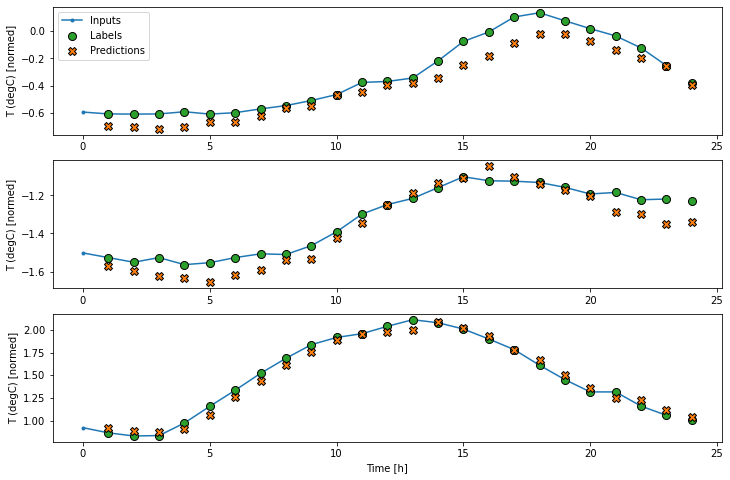

In [40]:
wide_window.plot(linear)

como es un modelo lineal, es sencillo de interpretar los pesos de este.

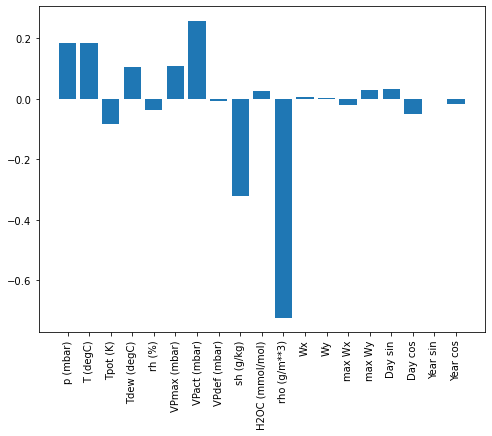

In [41]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

#### Denso Multi paso

El modelo a un paso no tiene contexto de los valores actuales, ni ve como estos cambian a través del tiempo. Para arreglar esto, usamos varios pasos de tiempo como entrada del modelo.

Los modelos anteriores tomaban cada paso de manera independiente. Aquí comenzará a tomar varios pasos como entrada para generar una sola salida

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/conv_window.png" 
     alt="ventaneo_6-1" width="300">
<center>

In [42]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

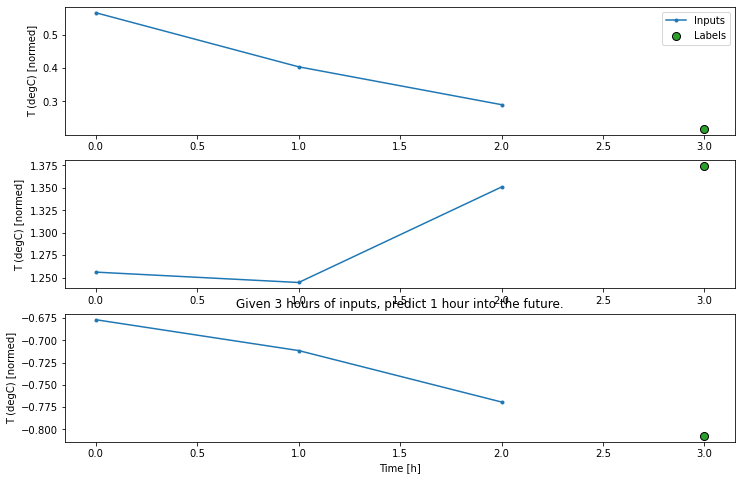

In [43]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

Logramos entrenar este modelo de multiple entrada agregando `tf.keras.layers.Flatten` como la primera capa

In [44]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [45]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [46]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 0s 978us/step - loss: 0.0078 - mean_absolute_error: 0.0640


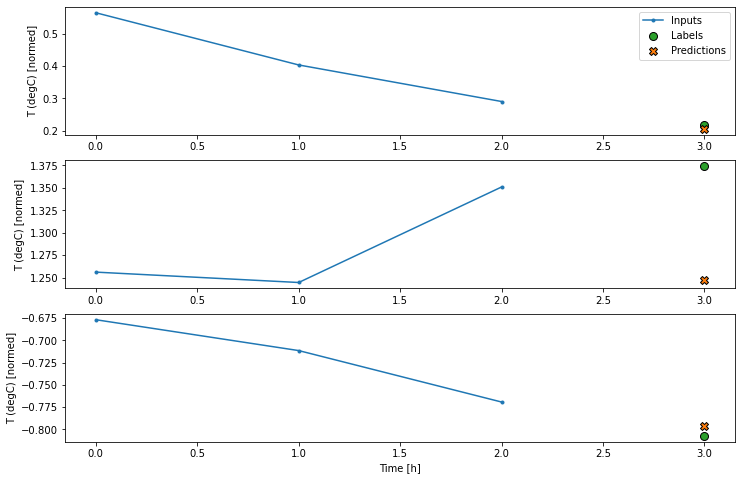

In [47]:
conv_window.plot(multi_step_dense)

La desventaja de estos datos es que sólo pueden ser ejecutados en ventanas de entrada de exactamente la misma forma, pero con el siguiente modelo se deshace este inconveniente

#### Red Neuronal Convolucional

una capa convolucional también toma los múltiples pasos de tiempo como entrada.

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/wide_conv_window.png" 
     alt="ventaneo_6-1" width="300">
</center>

Tendremos el mismo modelo que el caso anterior, pero con un par de diferencias

- Reemplazamos `layers.Flatten` y el primer `layers.Dense` por una capa `tf.keras.layers.Conv1D`
- No es necesario aplicar un `reshape`

In [48]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [49]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [50]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 1s 1ms/step - loss: 0.0065 - mean_absolute_error: 0.0579


Este modelo si puede ser aplicado a ventanas de tiempo más largas, y se generarán salidas más largas

In [51]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Para graficar estos resultados correctamente, los labels y la predicción deben tener el mismo tamaño. Así que usamos `WindowGenerator` para producir ventanas más largas con pasos extra en la entrada, para que los puntos anteriores coincidan 

In [52]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [53]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


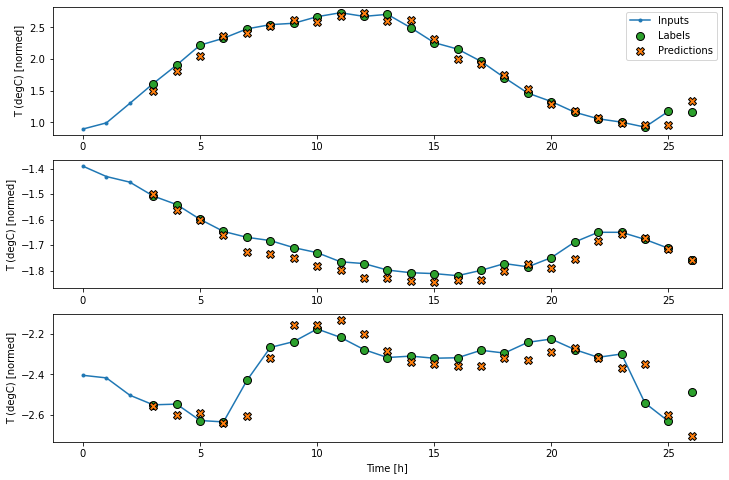

In [54]:
wide_conv_window.plot(conv_model)

### Red Recurrente

La preferente para datos secuenciales/Series de tiempo.

En este caso usaremos una capa `layers.LSTM`. Un parámetro importante de estas es el `return_sequences`, cuyo valor puede implicar dos cosas:

- Falso: la capa tiene de salida el último paso de tiempo. 

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png" 
     alt="ventaneo_6-1" width="300">
</center>
    
- Verdadero: habrá una salida por cada dato de entrada. Esto es principalmente usado cuando se tienen varias capas recurrentes
<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png" 
     alt="ventaneo_6-1" width="300">
</center>

In [55]:
lstm_model = tf.keras.models.Sequential([
    # forma [lote, pasos, variables] => [lote, pasos, unidades_lstm]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # forma => [lote, pasos, features]
    tf.keras.layers.Dense(units=1)
])

Con el `return_sequences=True`, el modelo se puede hacer un entrenamiendo de 24 horas a la vez

In [56]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [57]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0056 - mean_absolute_error: 0.0515


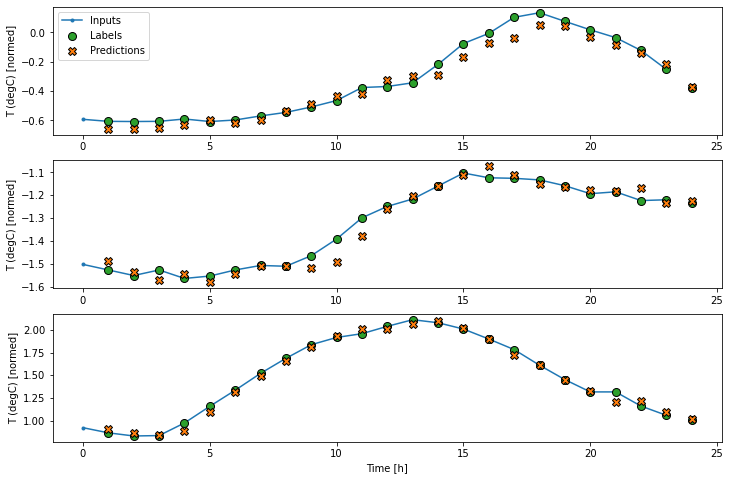

In [58]:
wide_window.plot(lstm_model)

#### Rendimiento

Vamos a ver cómo se diferencian los modelos 

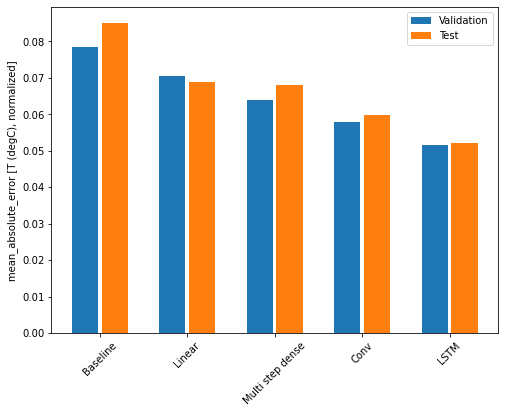

In [59]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [60]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0688
Multi step dense: 0.0681
Conv        : 0.0600
LSTM        : 0.0521


#### Modelos multivariados

Hasta ahora sólo hemos lidiado con predicciones de una variable, pero esto facilmente se puede extender a casos multivariados. Esto se hace cambiando la ventana de labels a la cantidad que buscamos

Observemos cómo se comporta la red recurrente con predicciones multivariadas

In [61]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

print(wide_window)

lstm_model = tf.keras.models.Sequential([
    # forma [lote, pasos, variables] => [lotes, pasos, unidades_lstm]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # forma => [lote, pasos, variables]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 1s 1ms/step - loss: 0.0618 - mean_absolute_error: 0.1208

CPU times: user 2min 23s, sys: 22.7 s, total: 2min 46s
Wall time: 55.3 s


Vemos que el valor "MAE" en el caso multivariado es mayor al del caso univariado. ¿cuál es la razón de esto?

### <span style="color:red">Modelo multi paso</span>

A pesar de hacer predicciones en grandes ventanas de tiempo, los modelos anteriores siguen haciendo predicciones a una hora en el futuro. Aquí, los modelos comenzaran a predecir múltiples pasos en el futuro, generando una franja completa de tiempo

Primero, generamos ventanas con 24 horas de historia para predecir 24 horas en el futuro

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

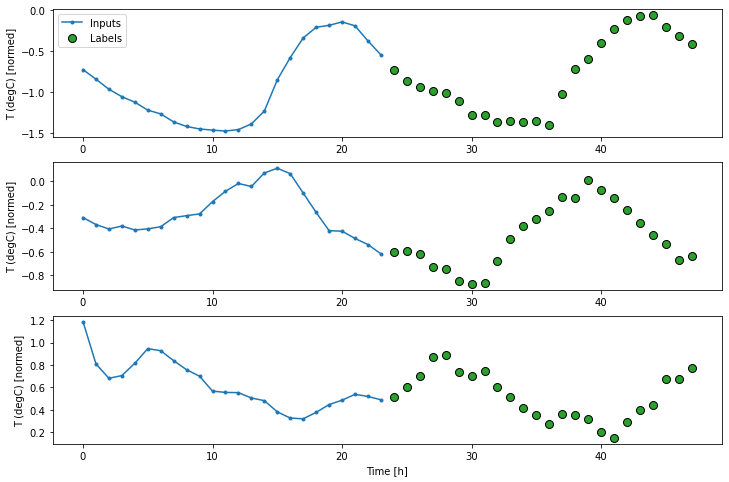

In [62]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#### Base de referencia

Haremos un modelo de referencia que simplemente repita el último paso de entrada para cada ventana de salida

437/437 [==============================] - 0s 868us/step - loss: 0.6285 - mean_absolute_error: 0.5007


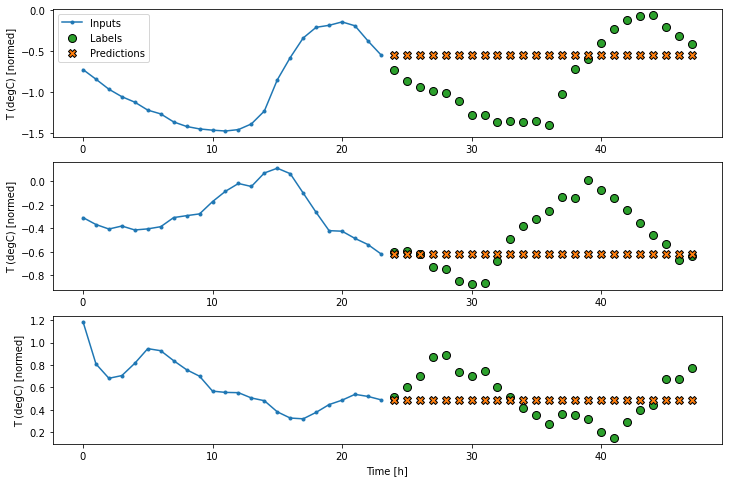

In [63]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Otro punto de referencia es repetir el dato de entrada en las siguientes 24 horas, haceindo la suposición de que el comportamiento va a ser similar en la misma hora

437/437 [==============================] - 0s 883us/step - loss: 0.4270 - mean_absolute_error: 0.3959


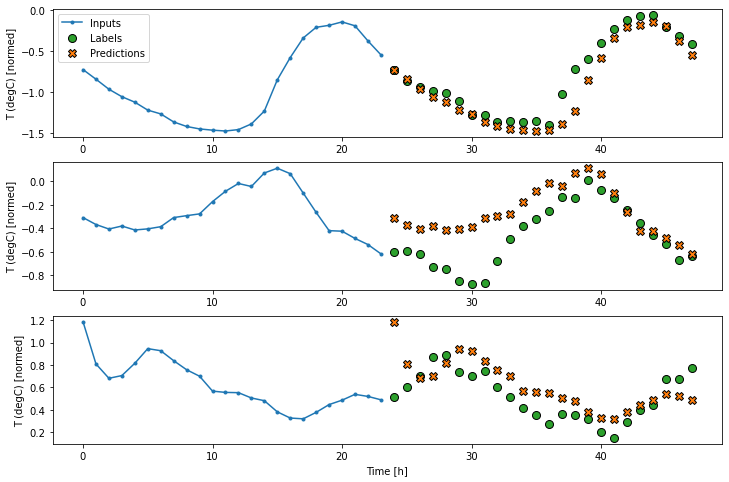

In [64]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

#### Modelos Single shot

Lo que se va a hacer en este modelo es predecir la secuencia entera de tiempo en un solo paso o en un solo "tiro". Esto se logra, por ejemplo definiendo las unidades de salida de una capa densa como `PASOS_SALIDA*variables`, después se cambia la forma de las salidas para que el resultado sea como una matriz



<center>
<img src="https://c.tenor.com/u2LD0oM-x30AAAAC/simpsons-makeup.gif" 
     alt="ventaneo_6-1" width="300">
<figcaption>Piénsenlo como una escopeta</figcaption>
</center>


Vamos a revisar los modelos anteriores y los pasaremos a multi paso

#### Lineal

Este modelo tendrá modelos de potencia ya que necesita predecir varios puntos a futuro a partir de uno de entrada

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/multistep_dense.png" 
     alt="ventaneo_6-1" width="300">
</center>

437/437 [==============================] - 1s 1ms/step - loss: 0.2562 - mean_absolute_error: 0.3059


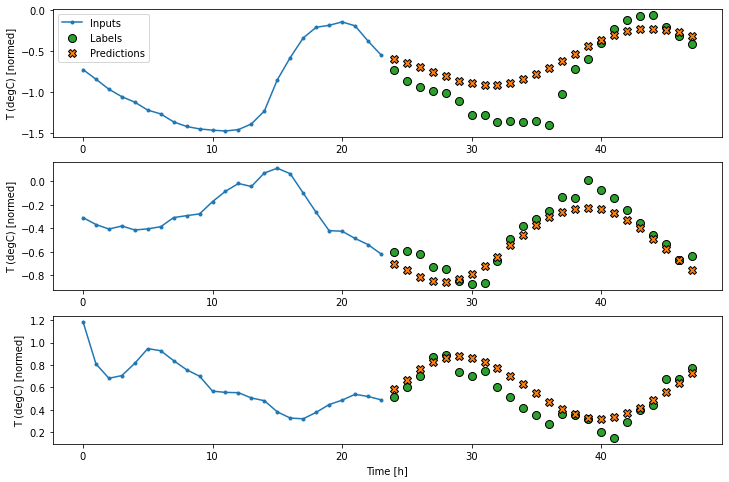

In [65]:
multi_linear_model = tf.keras.Sequential([
    # Toma el último paso de tiempo
    # forma [lote, tiempo, variables] => [lotes, 1, variables]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # forma => [lotes, 1, pasos_salida*variables]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # forma => [lote, pasos_salida, variables]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Densa

Agregando una capa densa le dará más poder a la red, pero sigue solo prediciendo a partir de un paso

437/437 [==============================] - 1s 1ms/step - loss: 0.2206 - mean_absolute_error: 0.2844


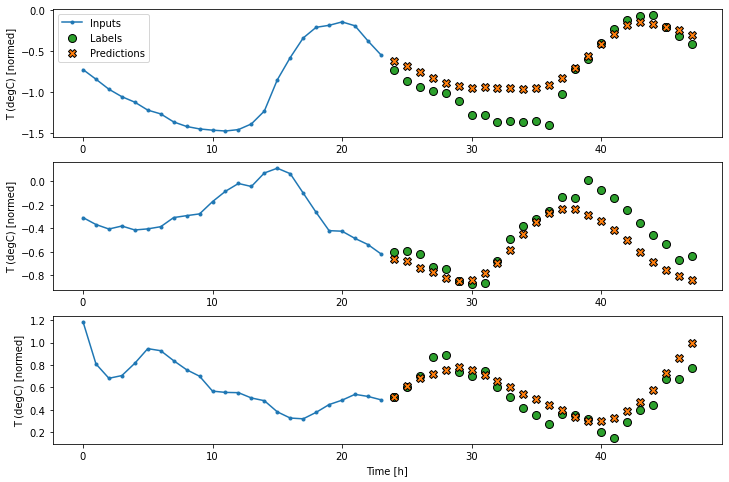

In [66]:
multi_dense_model = tf.keras.Sequential([
    # Toma el último paso de tiempo
    # forma [lote, tiempo, variables] => [lote, 1, variables]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # forma => [lote, 1, unidades_densas]
    tf.keras.layers.Dense(512, activation='relu'),
    # forma => [lote, pasos_salida*variables]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # forma => [lote, pasos_salida, variables]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

Usando capas convolucionales sobre una ventana de tiempo fija, la red comienza a observar los cambios a través del tiempo, razón por lo cuál mejorará su predicción

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/multistep_conv.png" 
     alt="ventaneo_6-1" width="300">
</center>

437/437 [==============================] - 1s 1ms/step - loss: 0.2131 - mean_absolute_error: 0.2801


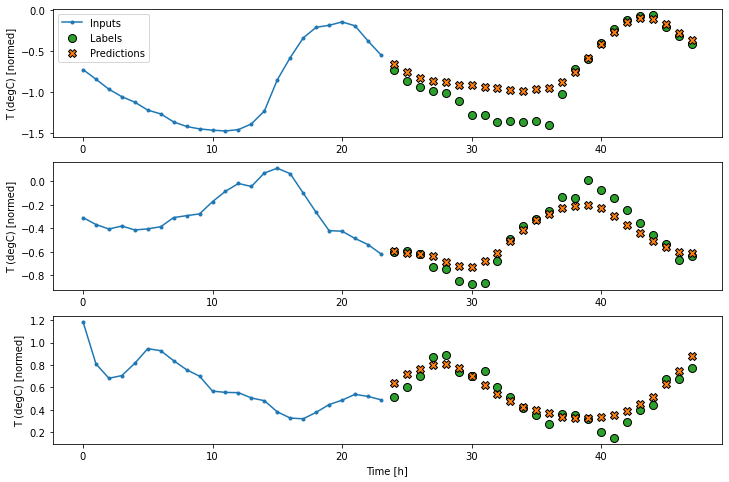

In [67]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # forma [lote, tiempo, variables] => [lote, CONV_WIDTH, variables]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # forma => [lote, 1, unidades_conv]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # forma => [lote, 1,  pasos_salida*variables]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # forma => [lote, pasos_salida, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

El modelo recurrente es capaz de usar la ventana completa de entradas para la predicción. Se guardará el estado de las últimas 24 horas antes de predecir las siguientes 24 horas.

En este formato "single-shot" solo se produce la salida en el último paso de tiempo, así que definimos `return_sequence=False` en la capa LSTM

<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png" 
     alt="ventaneo_6-1" width="300">
</center>

437/437 [==============================] - 1s 1ms/step - loss: 0.2133 - mean_absolute_error: 0.2835


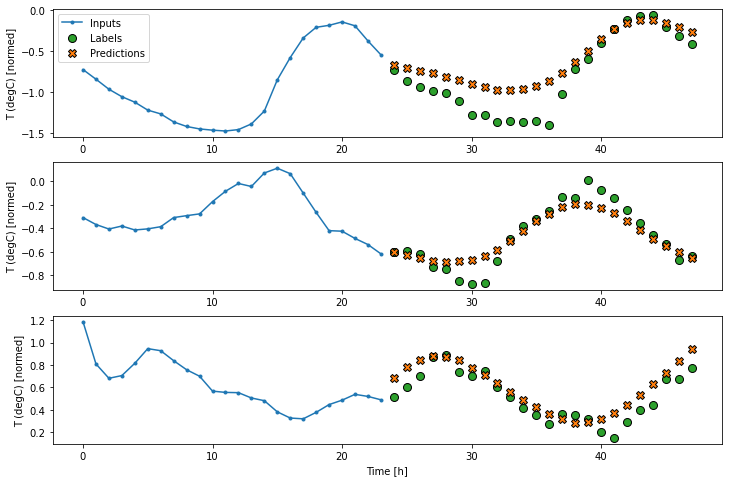

In [68]:
multi_lstm_model = tf.keras.Sequential([
    # forma [lote, tiempo, variables] => [lote, unidades_lstm].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Forma => [lote, pasos_salida*variables].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # forma => [lote, pasos_salida, variables].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

#### Modelo Autorregresivo

Los humanos no dejan de aprender después de cierto tiempo, sus conocimientos siguen creciendo a medidad que obtienen más experiencia. 
Una forma de obtener esta forma de aprendizaje es descomponiendo la franja de tiempo predicha en pasos de tiempo individuales. Luego, cada salida será alimentada de vuelta al modelo, permitiendo que la siguiente predicción tome en cuenta el dato predicho anteriormente


<center>
<img src="https://www.tensorflow.org/tutorials/structured_data/images/multistep_autoregressive.png" 
     alt="ventaneo_6-1" width="500">
</center>

Este "loop" de retroalimentación puede ser aplicado a cualquiera de los modelos multipaso propuestos. Pero aquí haremos desde 0 un modelo de redes   recurrentes que se entrene de esta manera. 

El modelo manejará de manera manual las entradas de cada paso, así que usamos una capa `tf.keras.layers.LSTMCell` de manera directa para cara paso de tiempo

In [69]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # envolvemos la capa LSTMCell en una RNN para simplificar el calentamiento.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [70]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

Esta clase necesita un método de "calentamiento", para inicializar su estado con base en las entradas. Estamos haciendo un pre entrenamiento para que se capturen más rápido las partes relevantes

In [71]:
def warmup(self, inputs):
    # inputs.shape => (lote, tiempo, variables)
    # x.shape => (lote, unidades_lstm)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (lote, variables)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

Esto retorna una predicción a un paso y el estado de la capa LSTM

In [72]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

Después podemos iterar el modelo, alimentandóle cada predicción. Esto lo logramos usando listas y `tf.stack` después de cada iteración

In [73]:
def call(self, inputs, training=None):
  # Usamos un TensorArray para capturar las salidas
  predictions = []
  # Inicializamos el estado LSTM
  prediction, state = self.warmup(inputs)

  # Insertamos la primera predicción
  predictions.append(prediction)

  # Corremos el resto de predicciones
  for n in range(1, self.out_steps):
    # Usamos la última predicción como entrada
    x = prediction
    # Ejecutamos un último paso LSTM.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convertimos la salida LSTM a predicción
    prediction = self.dense(x)
    # Añadimos la predicción a la salida
    predictions.append(prediction)

  # predictions.shape => (tiempo, lote, variables)
  predictions = tf.stack(predictions)
  # predictions.shape => (lote, tiempo, variables)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [74]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


437/437 [==============================] - 3s 6ms/step - loss: 0.2258 - mean_absolute_error: 0.3000


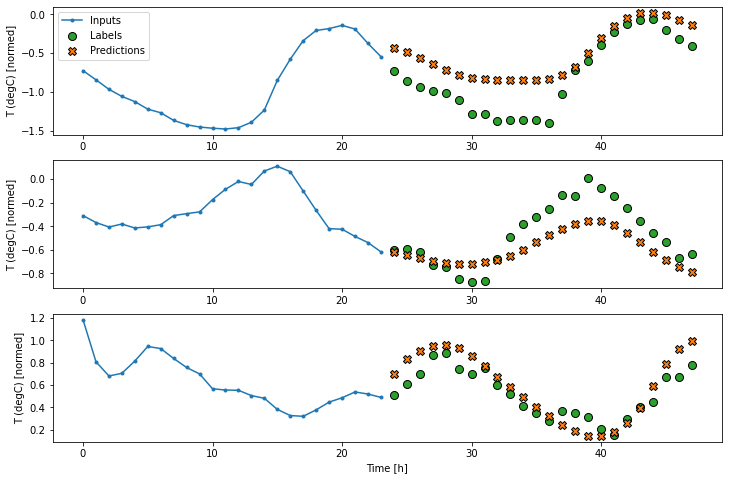

In [75]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

#### Rendimiento

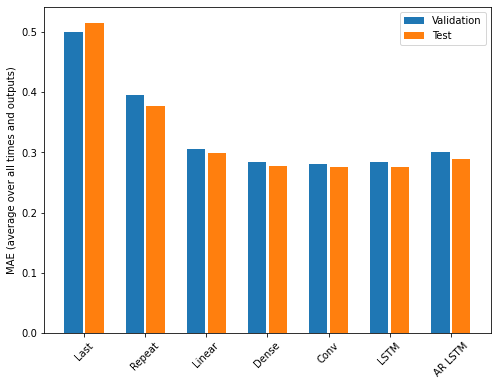

In [76]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [77]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2986
Dense   : 0.2770
Conv    : 0.2758
LSTM    : 0.2757
AR LSTM : 0.2898


¿Vale la pena el esfuerzo por el modelo más complejo?